# Data Analysis and Machine Learning Applications for Physicists

*Material for a* [*University of Illinois*](http://illinois.edu) *course offered by the* [*Physics Department*](https://physics.illinois.edu). *This content is maintained on* [*GitHub*](https://github.com/illinois-mla) *and is distributed under a* [*BSD3 license*](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from mls import nn_unit_draw2d, nn_graph_draw2d

In [3]:
import torch.nn

In [4]:
import mls.torch

## Neural Networks

From a user's perspective, a neural network (NN) is a class of models 

$$ \Large
X_\text{out} = N(X_\text{in}; \Theta)
$$
that are:
 - **Generic:** they are not tailored to any particular application.
 - **Flexible:** they can accurately represent a wide range of non-linear $X_\text{in}\rightarrow X_\text{out}$ mappings with a suitable choice of parameters $\Theta$.
 - **Trainable:** a robust optimization algorithm (backpropagation) can learn parameters $\Theta$ given enough training data $D = (X_\text{in},Y_\text{tgt})$.
 - **Modular:** it is straightforward to scale the model complexity (and number of parameters) to match the available training data.
 - **Efficient:** most of the internal computations are linear and amenable to parallel computation and hardware acceleration.

The "neural" aspect of a NN is tenuous. Their design mimics some aspects of biological neurons, but also differs in fundamental ways.

In this notebook, we will explore NNs from several different perspectives:
 - **Mathematical:** What equations describe a network?
 - **Visual:** What does the network graph look like? How is the input space mapped through the network?
 - **Data Flow:** What are the tensors that parameterize and flow (forwards and backwards) through a network?
 - **Statistical:** What are typical distributions of tensor values?

### Mathematical Perspective

#### Building Block

The internal structure of a NN is naturally described by a computation graph that connects simple building blocks. The basic building-block unit is a function of $D$ input features $x_i$,

$$ \Large
f(\mathbf{x}) = \phi\left(\mathbf{x}\cdot\mathbf{w} + b\right)
$$

with $D+1$ parameters consisting of $D$ **weights** $w_i$ and a single **bias** $b$. The corresponding [graph](http://alexlenail.me/NN-SVG/index.html) (with $D=8$) is:

![NN unit](img/NeuralNetworks/nn_unit.png)

where the left nodes correspond to the elements of the input $\mathbf{x}$, the edges correspond to the elements of $\mathbf{w}$ (thickness ~ strength, red/blue are pos/neg values), and the right node is the output value $f(\mathbf{x})$. The recipe for obtaining the output value is then:
 - propagate each input value $x_i$ with a strength $w_i$,
 - sum the values $x_i w_i$,
 - apply the activation $\phi$.

Note that this building block is mostly linear, except for the **activation function** $\phi(s)$. This is an application of the kernel trick that we met [earlier](Nonlinear.ipynb), and allows us to implicitly work in a higher dimensional space where non-linear structure in data is easier to model.

The building-block equation is straightfoward to implement as code:

In [5]:
def nn_unit(x, w, b, phi):
    return phi(np.dot(x, w) + b)

For example, with a 3D input $\mathbf{x}$, the weight vector $\mathbf{w}$ should also be 3D:

In [6]:
nn_unit(x=[0, 1, -1], w=[1, 2, 3], b=-1, phi=np.tanh)

-0.9640275800758169

#### Activation Functions

The activation function $\phi$ argument $s$ is always a scalar and, by convention, activation functions are always defined in a standard form, without any parameters (since $\mathbf{w}$ and $b$ already provide enough learning flexibility).

Some popular activations are defined below (using [lambda functions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)). For the full list supported in PyTorch see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [7]:
relu = lambda s: np.maximum(0, s)
elu = lambda s: np.maximum(0, s) + np.minimum(0, np.expm1(s)) # expm1(s) = exp(s) - 1
softplus = lambda s: np.log(1 + np.exp(s))
sigmoid = lambda s: 1 / (1 + np.exp(-s)) # also known as the "logistic function"
tanh = lambda s: np.tanh(s)
softsign = lambda s: s / (np.abs(s) + 1)

These activations divide naturally into two categories depending on their asymptotic behavior as $s\rightarrow +\infty$:

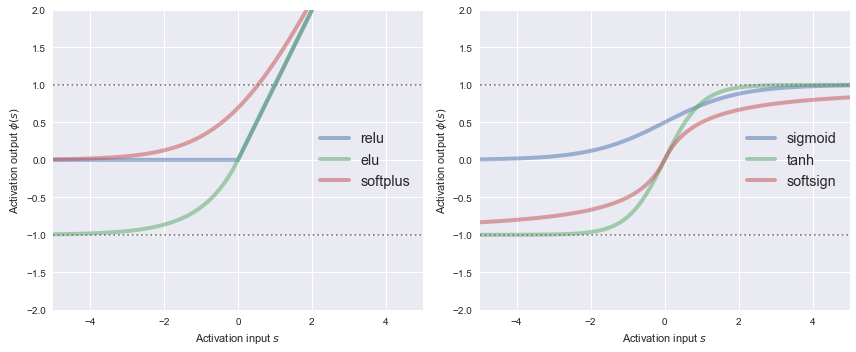

In [8]:
def plot_activations(ax, names, s_range=5, y_range=2):
    s = np.linspace(-s_range, +s_range, 101)
    for name in names.split(','):
        phi = eval(name)
        ax.plot(s, phi(s), lw=4, alpha=0.5, label=name)
    ax.legend(fontsize='x-large')
    ax.set_xlabel('Activation input $s$')
    ax.set_ylabel('Activation output $\phi(s)$')
    ax.set_xlim(-s_range, +s_range)
    ax.set_ylim(-y_range, +y_range)
    ax.axhline(-1, c='gray', ls=':')
    ax.axhline(+1, c='gray', ls=':')
    
_, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_activations(ax[0], 'relu,elu,softplus')
plot_activations(ax[1], 'sigmoid,tanh,softsign')
plt.tight_layout()

Note that all activations saturate (at -1 or 0) for $s\rightarrow -\infty$, but differ in their behavior when $s\rightarrow +\infty$ (linear vs saturate at +1).

**DISCUSS:**
 - Which activation would you expect to be the fastest to compute?
 - Which activations are better suited for a binary classification problem?

The `relu` activation is the fastest to compute since it does not involve any transcendental function calls (exp, log, ...).

The activations that are bounded on both sides only have a narrow range near $s=0$ where they distinguish between different input values, and otherwise are essentially saturated at one of two values.  This is desirable for classification, where the aim is to place $s=0$ close to the "decision boundary" (by learning a suitable bias).

---

#### Network Layer

What happens if we replace the vectors $\mathbf{x}$ and $\mathbf{w}$ above with matrices?

$$\Large
F(X) = \phi\left( X W + \mathbf{b}\right)
$$

If $X$ has shape $(N, D)$ and holds $N$ samples of $D$ features, then $W$ must have shape $(D, M)$ so $F(X)$ converts the $D$ input features into $M$ output features for each sample. We say that $F$ represents a linear network **layer** with $D$ input nodes and $M$ output nodes. Note that the bias is now a vector of $M$ bias values, one for each output value.

We cannot really add a vector $\mathbf{b}$ to the matrix $X W$ but we are using the "broadcasting" convention that this means add the same vector to each row (sample) of $X W$.  We also cannot apply $\phi(s)$ to a matrix, but we are using the "elementwise" convention that this means apply $\phi$ separately to each element of the matrix.

To connect this matrix version with our earlier vector version, notice that $F(X)$ transforms a single input sample $\mathbf{x}_i$ (row of $X$) into $M$ different outputs, $f_m(\mathbf{x}_i)$ each with their own weight vector and bias value:

$$\Large
f_m(\mathbf{x}_i) = \phi\left(\mathbf{x}_i\cdot \mathbf{w}_m + b_m\right) \; ,
$$

where $\mathbf{w}_m$ is the $m$-th column of $W$ and $b_m$ is the $m$-th element of $\mathbf{b}$.

The corresponding graph (with $D=8$ and $M=4$) is:

![NN layer](img/NeuralNetworks/nn_layer.png)

The `nn_unit` function we defined above already implements a layer if we pass it matrices $X$ and $W$ and a vector $\mathbf{b}$. For example:

In [9]:
nn_unit(x=[[1., 0.5], [-1, 1]], w=[[1, -1, 1], [2, 0, 1]], b=[-1, 1, 0], phi=sigmoid)

array([[0.73105858, 0.5       , 0.81757448],
       [0.5       , 0.88079708, 0.5       ]])

A layer with $n_{in}$ inputs and $n_{out}$ outputs has a total of $(n_{in} + 1) n_{out}$ parameters. These can add up quickly when building useful networks!

#### Network Graph

Finally, we can build a simple **fully connected graph** by stacking layers horizontally, which corresponds to nested calls of each layer's function. For example, with 3 layers computed by $F$, $G$, $H$ stacked (left to right), the overall graph computation is:

$$\Large
N(X) = H\left(G\left(F(X)\right)\right) \; ,
$$

with a corresponding graph:

![NN graph](img/NeuralNetworks/nn_graph.png)

Nodes between the input (leftmost) and output (rightmost) nodes are known as **hidden nodes**.

The corresponding code for arbitrary layers is:

In [10]:
def nn_graph(X, *layers):
    for W, b, phi in layers:
        X = nn_unit(X, W, b, phi)
    return X

For example, here is a three-layer network with the same architecture as the graph above. Note how the output dimension of one layer must match the input dimension of the next layer.

In [11]:
nn_graph([1, 2, 3, 4, 5, 6, 7, 8],
    ([
        [11, 12, 13, 14],
        [21, 22, 23, 24],
        [31, 32, 33, 34],
        [41, 42, 43, 44],
        [51, 52, 53, 54],
        [61, 62, 63, 64],
        [71, 72, 73, 74],
        [81, 82, 83, 84],
    ], [1, 2, 3, 4], tanh),    # LYR1: n_in=8, n_out=4
    ([
        [11, 12, 13],
        [21, 22, 23],
        [31, 32, 33],
        [41, 42, 43],
    ], [1, 2, 3], relu),       # LYR2: n_in=4, n_out=3
    ([
        [11, 12],
        [21, 22],
        [31, 32],
    ], [1, 2], sigmoid)        # LYR3: n_in=3, n_out=4
)

array([1., 1.])

The weight and bias values are chosen to make the tensors easier to read, but would not make sense for a real network. As a result, the final output of `[1., 1.]` is not surprising given how the sigmoid activation saturates for input outside a narrow range.

### Visual Perspective

![Activation maps](img/NeuralNetworks/activation_maps.png)

**EXERCISE:** Identify which activation function was used to make each plot above, which shows the building block 

$$
f(\mathbf{x}) = \phi\left(\mathbf{x}\cdot\mathbf{w} + b\right)
$$

for a 2D $\mathbf{x}$ with the same $\mathbf{w}$ and $b$ used in each plot. Red and blue indicate positive and negative values, respectively, with zero displayed as white. For calibration, (a) shows a "linear" activation which passes its input straight through.

- (a) linear
- (b) tanh
- (c) relu
- (d) softsign
- (e) sigmoid
- (f) elu

To distinguish between (b) and (d), note that both go asymptotically to constant negative and positive values (so sigmoid is ruled out), but the white transition region is narrower for (d).

To distinguish between (c) and (f), note that (c) goes asymptotically to zero (white) in the top-left corner, while (e) goes asymptotically to a constant negative value (blue).

---

**EXERCISE:** Experiment with the following function to determine how the displayed arrow relates to the three model parameters $w_0, w_1, b$:
```
nn_unit_draw2d(w=[0, 2], b=-1, phi=tanh)
```

The arrow has the direction and magnitude of the 2D vector $\mathbf{w}$, with its origin at $\mathbf{x} = -b \mathbf{w}\, / \, |\mathbf{w}|^2$ where $s = 0$. The line $s=0$ is perpendicular to the arrow.

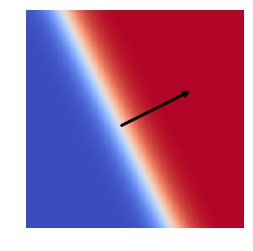

In [12]:
nn_unit_draw2d(w=[2, 1], b=+1, phi=tanh)

Study the plots below which show the hidden (left) and output (right) node values for a network with 2 + 2 + 1 nodes. Each graph shows the node value as a function of the 2D input value.

Note how the hidden nodes divide the input space into two halves, with a dividing line determined by their $\mathbf{w}$ and $b$ values. The output layer then mixes these halves and can therefore "select" any of the four quadrants with an appropriate choice of its $\mathbf{w}$ and $b$.

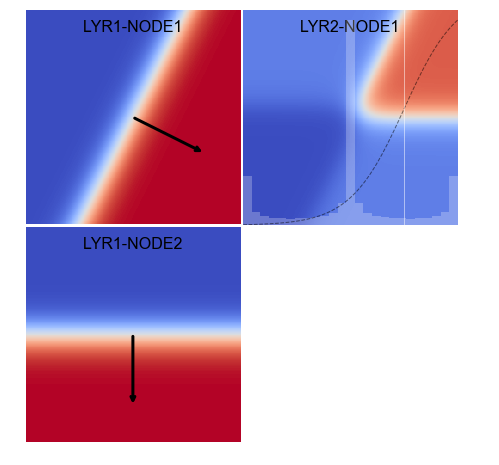

In [13]:
nn_graph_draw2d(
    ([[2, 0],[-1, -2]], [0, 0], tanh), # LYR1
    ([[1], [-1]], [-1], tanh)          # LYR2
)

The histogram on the second layer plot shows the distribution of

$$\Large
s = X W  + b
$$

feeding its activation function (shown as the dashed curve). Note how the central histogram peak is higher because both the lower-right and upper-left quadrants of $(x_1, x_2)$ have $Y W \simeq 0$. The vertical white line shows how our choice of bias $b = -0.5$ places these quadrants in the "rejected" (blue) category with $s < 0$.

Generalizing this example, a layer with $n$ inputs can "select" a different $n$-sided (soft-edged) polygon with each of its outputs. To see this in action, try [this demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html).

### Data Flow Perspective

The diagram below show the tensors flowing forward (left to right) in a typical fully connected graph. The main flow consists of $N$ input samples flowing from $X_0$ to $X_4$ with a number of features that varies between layers. 

The computation of each layer's output is parameterized by the weight and bias tensors shown: note how their shapes are determined by the number of input and output features for each layer. The parameter tensors are usually randomly initialized (more on this soon) so only the input $X_0$ and target $Y$ are needed to drive the calculation (and so must be copied to GPU memory when using hardware acceleration).

The final output $X_4$ is compared with the target values $Y$ to calculate a "loss" $\ell(X_4, Y)$ that decreases as $X_4$ becomes more similar to $Y$ (more on this soon).

![forward flow](img/NeuralNetworks/forward_flow.png)

The diagram below shows the gradient (partial derivative) tensors flowing backwards ("backpropagation") through the same graph using the chain rule:

$$\Large
\frac{\partial \ell}{\partial X_n} = \frac{\partial \ell}{\partial X_{n+1}} \frac{\partial X_{n+1}}{\partial X_n}
\quad, \quad
\frac{\partial \ell}{\partial W_{n+1}} = \frac{\partial \ell}{\partial X_{n+1}} \frac{\partial X_{n+1}}{\partial W_{n+1}} \; .
$$

![backward flow](img/NeuralNetworks/backward_flow.png)

Note that these gradient tensors are just numbers, not functions. All of these tensors occupy the (limited) GPU memory when using hardware acceleration but, in most applications, only the final output and the parameter gradients are stored (with 32-bit floating point precision).

When working with large datasets, the $N$ input samples are usually broken up into fixed-size randomly subsampled "minibatches". Optimiztion with the resulting parameter gradients leads to the "stochastic gradient descent" (SGD) algorithm.

### PyTorch Primer

A fully connected network can be created with a few lines in PyTorch (for a similar high-level API in Tensorflow checkout [Keras](https://www.tensorflow.org/guide/keras)):

In [14]:
torch.manual_seed(123)

net = torch.nn.Sequential(
    torch.nn.Linear(8, 4), #0
    torch.nn.ReLU(),    #1
    torch.nn.Linear(4, 3), #2
    torch.nn.ReLU(),    #3
    torch.nn.Linear(3, 2)  #4
)

As each `Linear` layer is created, its weight and bias tensors are automatically initialized with random values, so we initially set the torch random seed for reproducible results.

This construction breaks each layer into separate linear and activation "modules". Each module can be accessed via its index (0-4 in this example):

In [15]:
print(net)

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
)


In [16]:
net[2].weight

Parameter containing:
tensor([[-0.4228, -0.1435, -0.3521,  0.0331],
        [-0.0934, -0.2682, -0.0455,  0.4737],
        [-0.0394,  0.0159, -0.0780,  0.0786]], requires_grad=True)

In [17]:
net[4].bias

Parameter containing:
tensor([0.4928, 0.0345], requires_grad=True)

To run our network in the forward direction, we need some data with the expected number of features ($D=8$ in this example):

In [18]:
N = 100
D = net[0].in_features
Xin = torch.randn(N, D)

In [19]:
Xout = net(Xin)

The intermediate tensors ($X_1$, $\partial\ell/\partial X_1$, ...) shown in the data flow diagrams above are usually not preserved, but can be useful to help understand how a network is performing and diagnose problems. To cache these intermediate tensors, use:

In [20]:
mls.torch.trace(net)

In [21]:
Xout = net(Xin)

Each submodule now has `input` and `output` attributes:

In [22]:
torch.equal(Xin, net[0].input)

True

In [23]:
torch.equal(net[0].output, net[1].input)

True

Use the `verbose` option to watch the flow of tensors through the network:

In [24]:
mls.torch.trace(net, verbose=True)
Xout = net(Xin)

0: IN (100, 8) OUT (100, 4)
1: IN (100, 4) OUT (100, 4)
2: IN (100, 4) OUT (100, 3)
3: IN (100, 3) OUT (100, 3)
4: IN (100, 3) OUT (100, 2)


To complete the computational graph we need to calculate a (scalar) loss, for example:

In [25]:
loss = torch.mean(Xout ** 2)
print(loss)

tensor(0.1996, grad_fn=<MeanBackward1>)


We can now back propagate gradients of this loss through the network:

In [26]:
loss.backward()

4: GRAD (100, 2)
3: GRAD (100, 3)
2: GRAD (100, 3)
1: GRAD (100, 4)
0: GRAD (100, 4)


The gradients of each layer's parameters are now computed and stored, ready to "learn" better parameters through (stochastic) gradient descent (or one of its variants):

In [27]:
net[0].bias.grad

tensor([-0.0285, -0.0276, -0.0335,  0.0646])

Using `mls.torch.trace` we have also captured the gradients of the loss with respect to each module's outputs $\partial\ell /\partial X_n$:

In [28]:
net[0].output.size(), net[0].grad.size()

(torch.Size([100, 4]), torch.Size([100, 4]))

These gradients can be useful to study since learning of all upstream parameters effectively stops when they become vanishly small (since they multiply those parameter gradients via the chain rule).

### Statistical Perspective

The tensors behind a practical network contain so many values that it is usually not practical to examine them individually. However, we can still gain useful insights if we study their probability distributions.

Build a network to process a large dataset so we have some distributions to study:

In [29]:
torch.manual_seed(123)

N, D = 500, 100
Xin = torch.randn(N, D)

net = torch.nn.Sequential(
    torch.nn.Linear(D, 2 * D),
    torch.nn.Tanh(),
    torch.nn.Linear(2 * D, D),
    torch.nn.ReLU(),
    torch.nn.Linear(D, 10)
)
print(net)

Sequential(
  (0): Linear(in_features=100, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)


Note that our network ends with a `Linear` module instead of an activation, which is typical for regression problems.

Perform forward and backward passes to capture some values:

In [30]:
mls.torch.trace(net, verbose=True)

In [31]:
Xout = net(Xin)
loss = torch.mean(Xout ** 2)
loss.backward()

0: IN (500, 100) OUT (500, 200)
1: IN (500, 200) OUT (500, 200)
2: IN (500, 200) OUT (500, 100)
3: IN (500, 100) OUT (500, 100)
4: IN (500, 100) OUT (500, 10)
4: GRAD (500, 10)
3: GRAD (500, 100)
2: GRAD (500, 100)
1: GRAD (500, 200)
0: GRAD (500, 200)


First check that the input to the first module has the expected (unit normal) distribution:

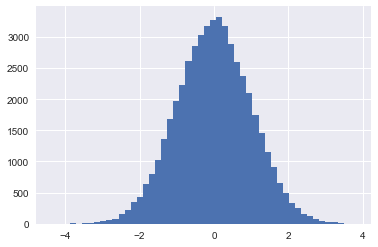

In [32]:
plt.hist(net[0].input.reshape(-1), bins=50);

How does torch initialize the parameters (weights and biases) for each layer?

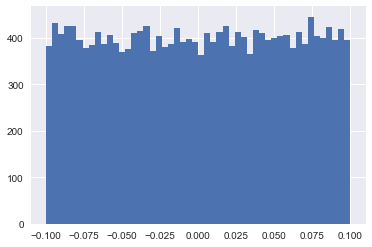

In [33]:
plt.hist(net[0].weight.data.reshape(-1), bins=50);

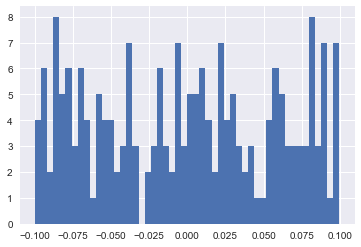

In [34]:
plt.hist(net[0].bias.data, bins=50);

These initial parameter values are sampled from uniform distributions centered on zero with a spread that depends on the number of inputs to the layer:

$$\Large
\left|W_{ij}\right|, \left|b_j\right| \le n_{in}^{-1/2} \; .
$$

This default choice is based on [empirical studies](https://arxiv.org/abs/1502.01852) of image classification problems where the input features (RGB pixel values) were preprocessed to have zero mean and unit variance.

With this choice of weights, the first `Linear` module mixes up its input values ($X_0$) but generally preserves Gaussian shape while slightly reducing its variance (which helps prevent the subsequent activation module from saturating):

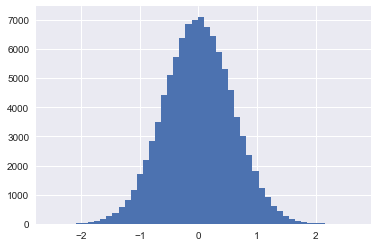

In [35]:
plt.hist(net[0].output.reshape(-1), bins=50);

A scatter plot of the the first `Tanh` activation function's input and output values just traces out function since it is applied element wise.  Note how most of input values do not saturate, which is generally desirable for efficient learning.

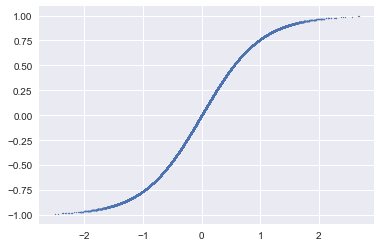

In [36]:
plt.scatter(net[1].input.reshape(-1), net[1].output.reshape(-1), s=1);

The non-linear activation distorts and clips the output so it no longer resembles a Gaussian:

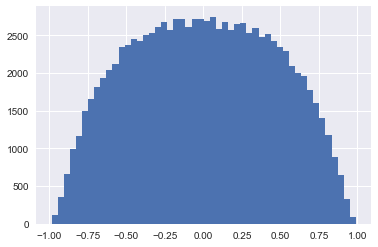

In [37]:
plt.hist(net[1].output.reshape(-1), bins=50);

However, the next `Linear` module restores the Gaussian distribution!  How does this happen when neither its inputs nor its parameters have a Gaussian distribution? (Answer: the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) which we briefly covered [earlier](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Statistics.ipynb)).

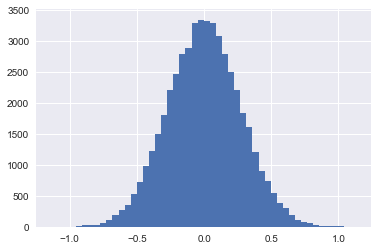

In [38]:
plt.hist(net[2].output.reshape(-1), bins=50);

The next activation is `ReLU`, which effectively piles up all negative values from the previous `Linear` module into the zero bin:

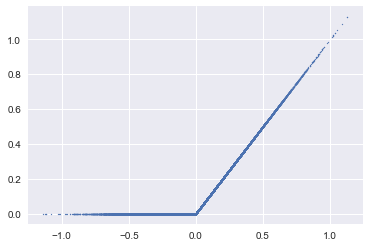

In [39]:
plt.scatter(net[3].input.reshape(-1), net[3].output.reshape(-1), s=1);

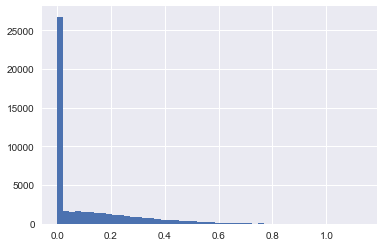

In [40]:
plt.hist(net[3].output.reshape(-1), bins=50);

The final linear layer's output is again roughly Gaussian, thanks to the central limit theorem:

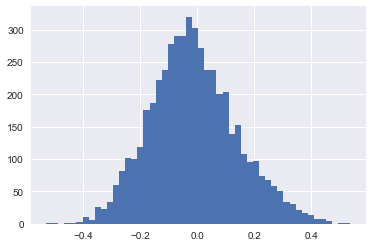

In [41]:
plt.hist(net[4].output.reshape(-1), bins=50);

So far we have only looked at distributions of the tensors involved in the forward pass, but there is also a lot to learn from the backwards gradient tensors that we do not have time to delve in to.  For example, this scatter plot offers some insight into a suitable learning rate for the second `Linear` module's weight parameters:

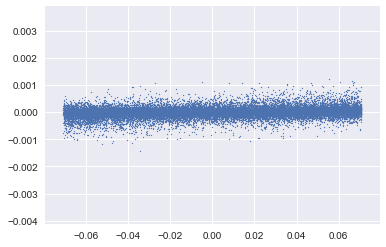

In [42]:
plt.scatter(net[2].weight.data.reshape(-1), net[2].weight.grad.reshape(-1), s=1);

Note that the normalization of the loss function feeds directly into these gradients, so needs to be considered when setting the learning rate:

In [43]:
Xout = net(Xin)
loss = 100 * torch.mean(Xout ** 2)
loss.backward()

0: IN (500, 100) OUT (500, 200)
1: IN (500, 200) OUT (500, 200)
2: IN (500, 200) OUT (500, 100)
3: IN (500, 100) OUT (500, 100)
4: IN (500, 100) OUT (500, 10)
4: GRAD (500, 10)
3: GRAD (500, 100)
2: GRAD (500, 100)
1: GRAD (500, 200)
0: GRAD (500, 200)


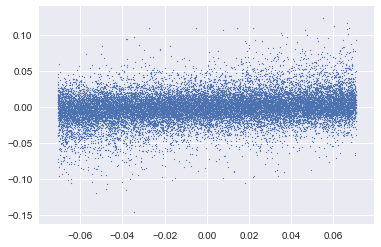

In [44]:
plt.scatter(net[2].weight.data.reshape(-1), net[2].weight.grad.reshape(-1), s=1);

### Loss Functions

In order discover a good set of parameters using optimization, we need to specify a loss function to optimize.

The loss function $\ell(X_\text{out}, Y_\text{tgt})$ compares the actual network output $X_\text{out}$ with a corresponding target value $Y_\text{tgt}$ and approaches some minimum value as their agreement improves.

A loss function must be scalar valued since we need a single gradient for each parameter to implement gradient descent,
$$\Large
\theta \rightarrow \theta_i - \eta\,\frac{\partial\ell}{\partial\theta} \; .
$$
Note that the loss normalization is degenerate with the learning rate $\eta$.

Our choice of loss function is primarily driven by the type of problem we are solving: regression or classification. We introduce the most obvious choices below but there are lots of reasonable variations (see [here](https://pytorch.org/docs/stable/nn.html#id51) for the complete PyTorch list).

#### Regression Loss

For regression, the $L_2$ norm is a popular choice,
$$\Large
L_2 = \frac{1}{2}\, \left|
X_\text{out} - Y_\text{tgt}\right|^2 \; .
$$
Optimizing the $L_2$ norm is equivalent to finding the maximum-likelihood (ML) point estimate for the network parameters (weights and biases) if we assume that the uncertainties in $Y_\text{tgt}$ are "homoscedastic" (drawn from the same Gaussian distribution).

In PyTorch, the $L_2$ norm is implemented as [torch.nn.MSELoss](https://pytorch.org/docs/stable/nn.html#mseloss):

In [45]:
Y = torch.zeros_like(Xout)
loss = torch.nn.MSELoss()(Xout, Y)

In case you actually have a reasonable estimate $\sigma_Y^i$ of the $i$-th sample's target uncertainty, a better loss function is the $\chi^2$ statistic:
$$\Large
\chi^2 = \sum_{i=1}^N\, \left( \frac{X_\text{out}^i - Y_\text{tgt}^i}{\sigma_Y^i}\right)^2 \; .
$$

#### Binary Classification Loss

For binary classification problems, the L2 norm can also be used but the binary [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the target and output probability distributions is often a better choice:

$$\Large
\text{BCE} \equiv -\sum_{i=1}^N\, \left[
Y_{tgt}^i \log \phi_S(X_\text{out}^i) + (1 - Y_\text{tgt}^i) \log (1 - \phi_S(X_\text{out}^i)) \right]
$$

where $\phi_S$ is the sigmoid (aka logistic) activation function used to coerce arbitrary real values into the range $[0,1]$ required for a probability. An input real value used with sigmoid like this is known as a [logit](https://en.wikipedia.org/wiki/Logit).

The equivalent PyTorch code uses [torch.nn.BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss):

In [46]:
Xout = torch.ones(10)
Y = torch.zeros(10)
loss = torch.nn.BCELoss()(Xout, Y)

The cross entropy is inspired by information theory and closely related to the KL divergence we met [earlier](Variational.ipynb). With this approach, our assumptions are that:
 - The target values in $Y_{tgt}$ are all either 0 or 1.
 - The network output values in $X_{out}$ are continuous and $\phi_S(y^{out}_i)$ is interpreted as the corresponding probability that the output is 1.
 
Note that *something* like the second assumption is necessary to reconcile the different domains of the data and prediction.

With these assumptions, the likelihood is:

$$\Large
P(Y_\text{tgt}\mid X_\text{out}) = \begin{cases}
\phi_S(X_\text{out}) & Y_\text{tgt} = 1 \\
1 - \phi_S(X_\text{out}) & Y_\text{tgt} = 0
\end{cases}
$$

Take a minute to convince yourself that the following expression is equivalent (the case $\phi_S(X_\text{out}(\Theta)) = Y_\text{tgt} = 0$ requires some care since $0^0$ is indeterminate):

$$\Large
P(Y_\text{tgt}\mid X_\text{out}(\Theta)) = \left[\phi_S(X_\text{out}(\Theta))\right]^{Y_\text{tgt}}\,
\left[1 - \phi_S(X_\text{out}(\Theta))\right]^{1-Y_\text{tgt}} \; .
$$

Using this form, you can show that the cross entropy loss equals the negative-log-likelihood of the $N$ samples of training data so optimizing BCE is equivalent to finding the ML point estimate of the network parameters under the assumptions above.

For fixed training data, optimizing BCE is also equivalent to minimizing the KL divergence of the network's predicted discrete probability distribution with respect to the empirical discrete probability distribution of the training data. Therefore, training a binary classification network using the cross-entropy loss is effectively performing a variational inference (VI) to find the network probabilities that are closest to the empirical training probabilities.

#### Multi-category Classification Loss

How can we generalize the binary classification cross-entropy loss to problems with more than two categories?  The usual approach is to increase the number of output nodes from 1 to the number of categories $C$,
but we can not directly interpret their values as category probabilities since there is no way to ensure that they sum to one. We could simply require that they are all non-negative and renormalize, but a more more robust approach is to convert the vector of output values $X_\text{out}$ to a corresponding vector of probabilities $\mathbf{p}$ for category $j = 1, 2, \ldots, C$ using the **softmax function**,

$$\Large
\mathbf{p}(X_\text{out}) \equiv \frac{1}{\sum_{k=1}^C\, \exp(X_\text{out}^k)}\,
[ \exp(X_\text{out}^1), \exp(X_\text{out}^2), \ldots, \exp(X_\text{out}^C) ] \; ,
$$

which works fine with positive or negative outputs $X_\text{out}^j$. Note that softmax generalizes the sigmoid function $\phi_S$ in the following sense:

$$\Large
\mathbf{p}([y_1, y_2]) = [\,\phi_S(y_1-y_2)\,,\, 1 - \phi_S(y_1-y_2)\,] \; .
$$

In [47]:
def softmax(y):
    # subtract out max(y) improve the numerical accuracy
    expy = np.exp(y - np.max(y))
    return expy / expy.sum()

In [48]:
softmax([2, -1, 3])

array([0.26538793, 0.01321289, 0.72139918])

The softmax function effectively implements a *winner takes all* policy, similar to the sigmoid activation $\phi_S$, as illustrated in the plot below where:
 - the color scale indicates, from left to right, $p_1, p_2$ and $p_3$ for three categories,
 - $y_1$ and $y_2$ are varied over the same range, and
 - $y_3$ is fixed to the middle of this range.

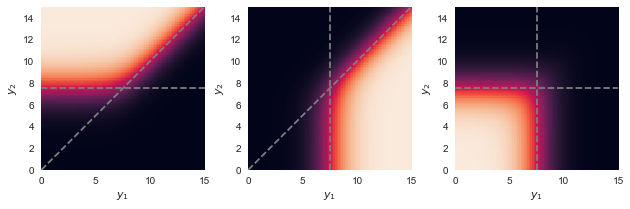

In [49]:
def plot_softmax(ylo, yhi, n=100):
    y_grid = np.linspace(ylo, yhi, n)
    y3 = 0.5 * (ylo + yhi)
    p_grid = np.array([softmax([y1, y2, y3]) for y1 in y_grid for y2 in y_grid]).reshape(n, n, 3)
    _, ax = plt.subplots(1, 3, figsize=(10.5, 3))
    for k in range(3):
        ax[k].imshow(p_grid[:, :, k], interpolation='none', origin='lower', extent=[ylo, yhi, ylo, yhi])
        ax[k].set_xlabel('$y_1$')
        ax[k].set_ylabel('$y_2$')
        if k != 0: ax[k].axvline(y3, c='gray', ls='--')
        if k != 1: ax[k].axhline(y3, c='gray', ls='--')
        if k != 2: ax[k].plot([ylo, yhi], [ylo, yhi], c='gray', ls='--')
        ax[k].grid(False)
    
plot_softmax(0, 15)

The example above assumed output activations that can be large an positive, such as `relu` or `elu`. However, the strength of the *winner takes all* effect depends on how the outputs are scaled, and is relatively weak for output activations that saturate on both sides, such as `sigmoid` or `tanh`, which is why these are generally not used for classification outputs:

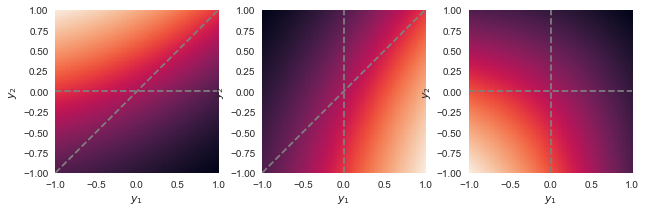

In [50]:
plot_softmax(-1, +1)

Note that we assume **one-hot encoding** of the vector target values $\mathbf{y}^{out}$, which is not very efficient (unless using sparse-optimized data structures) compared to a single integer target value $y^{train} = 0, 1, \ldots, C-1$. However, sklearn has a [convenient utility](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to convert integers to one-hot encoded vectors (use `sparse=True` to return vectors in an efficient [scipy sparse array](https://docs.scipy.org/doc/scipy/reference/sparse.html)).